
#  Pairs Trading Strategy

Welcome to this quantitative research notebook on **Pairs Trading**, a classic example of statistical arbitrage. This project is part of my GitHub Quantitative Finance portfolio, showcasing my skills in financial data analysis, time series modeling, and market-neutral strategy development.

##  Objective

The aim of this research is to:

- Identify cointegrated asset pairs using statistical tests
- Model the spread between asset prices
- Design and backtest a mean-reverting trading strategy based on the spread dynamics

This notebook walks through the full research pipeline from **data preprocessing**, **cointegration testing**, and **signal generation**, to **performance evaluation** with key metrics and visualizations.

##  Tools & Techniques

- Python (NumPy, Pandas, statsmodels, matplotlib, seaborn)
- Cointegration test (Engle-Granger / Johansen)
- Z-score normalization
- Signal generation via spread thresholds
- Backtesting of long/short positions
- Performance metrics: Sharpe Ratio, drawdowns, cumulative returns

##  Data

The dataset includes historical daily prices of multiple assets. The selection of asset pairs and the strategy performance are based entirely on statistical relationships, not on any fundamental information.

##  Why Pairs Trading?

Pairs trading is a widely used **market-neutral strategy** that profits from temporary deviations in price relationships of historically correlated or cointegrated assets. This notebook demonstrates how such strategies can be systematically researched, implemented, and evaluated using modern Python tools.




# Loading data

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import yfinance as yf

#Import Model Packages
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

**Retrieve S&P 500 Tickers**

We scrape the list of S&P 500 companies from Wikipedia using `pandas.read_html()` and clean the dataset by removing unnecessary columns.


In [ ]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
df=df.drop(columns=['GICS Sub-Industry','Headquarters Location', 'Date added', 'CIK', 'Founded'])
df

,Symbol,Security,GICS Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ACN,Accenture,Information Technology
...,...,...,...
498,XYL,Xylem Inc.,Industrials
499,YUM,Yum! Brands,Consumer Discretionary
500,ZBRA,Zebra Technologies,Information Technology
501,ZBH,Zimmer Biomet,Health Care


In [ ]:
symbols = df.Symbol.tolist()
symbols = [s.replace('.', '-') for s in symbols]

**Download Historical Price Data**

We use `yfinance` to fetch daily price data for all S&P 500 tickers over a one-year period. We specifically extract the `Adj Close` column, which accounts for dividends and splits.


In [ ]:
start = "2023-01-01"
end = "2024-01-01"
data = yf.download(
    symbols,
    start=start,
    end=end,
    group_by='ticker',
    auto_adjust=False,       # download 'Adj Close' separately
    threads=True
)
data

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['SW', 'GEV', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1704085200")')


Ticker            BXP                                                       \
Price            Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2023-01-03  68.150002  69.099998  66.360001  66.620003  57.147839  1746100   
2023-01-04  66.209999  67.919998  66.209999  66.709999  57.225040  1769200   
2023-01-05  66.089996  66.190002  64.180000  64.180000  55.054760  1680600   
2023-01-06  64.489998  67.230003  64.029999  67.050003  57.516701  1458900   
2023-01-09  66.980003  67.699997  65.709999  65.720001  56.375801  1285100   
...               ...        ...        ...        ...        ...      ...   
2023-12-22  71.870003  72.820000  70.160004  70.870003  64.089622   807100   
2023-12-26  71.129997  72.510002  70.750000  72.059998  65.165771   584400   
2023-12-27  72.099998  72.139999  71.080002  71.730003  64.867340   839900   
2023-12-28  70.510002  71.959999  69.959999  71.949997  65.967560   844400   
2023-12-29  71.639999  71.730003  70.129997  70.169998  64.335571   915400   

Ticker              GD                                      ...        BEN  \
Price             Open        High         Low       Close  ...        Low   
Date                                                        ...              
2023-01-03  247.850006  249.410004  246.320007  248.600006  ...  26.700001   
2023-01-04  247.490005  248.759995  242.960007  245.220001  ...  27.389999   
2023-01-05  244.550003  246.470001  243.789993  244.619995  ...  27.150000   
2023-01-06  247.320007  251.940002  245.000000  248.250000  ...  27.590000   
2023-01-09  248.550003  249.619995  244.550003  245.210007  ...  28.270000   
...                ...         ...         ...         ...  ...        ...   
2023-12-22  253.369995  255.259995  252.559998  254.100006  ...  29.580000   
2023-12-26  254.039993  256.809998  253.850006  256.209991  ...  29.600000   
2023-12-27  255.380005  257.730011  255.080002  257.429993  ...  29.910000   
2023-12-28  257.970001  258.790009  257.459991  258.140015  ...  29.980000   
2023-12-29  258.519989  259.880005  257.850006  259.670013  ...  29.680000   

Ticker                                          CHRW                        \
Price           Close  Adj Close   Volume       Open       High        Low   
Date                                                                         
2023-01-03  27.120001  23.764904  4213500  91.690002  92.709999  88.320000   
2023-01-04  27.830000  24.387068  3450700  87.589996  91.080002  86.940002   
2023-01-05  27.330000  23.948923  1955200  89.110001  90.199997  88.400002   
2023-01-06  28.379999  24.869026  2889500  91.089996  93.430000  90.559998   
2023-01-09  28.510000  24.982943  3521500  93.389999  94.370003  91.889999   
...               ...        ...      ...        ...        ...        ...   
2023-12-22  29.700001  26.955944  1877600  85.940002  87.620003  85.639999   
2023-12-26  30.080000  27.300837  1791900  87.279999  87.989998  86.900002   
2023-12-27  30.180000  27.391596  1454500  87.160004  87.410004  86.489998   
2023-12-28  30.059999  27.282684  1407000  86.879997  87.300003  86.470001   
2023-12-29  29.790001  27.037630  2031900  86.739998  87.300003  85.930000   

Ticker                                     
Price           Close  Adj Close   Volume  
Date                                       
2023-01-03  90.279999  84.463074  2124200  
2023-01-04  90.800003  84.949570  2246900  
2023-01-05  90.010002  84.210480  1717300  
2023-01-06  93.309998  87.297859  1113800  
2023-01-09  93.360001  87.344635  1954800  
...               ...        ...      ...  
2023-12-22  87.269997  83.848267   758700  
2023-12-26  87.250000  83.829056   626100  
2023-12-27  86.860001  83.454346   511900  
2023-12-28  86.889999  83.483154   530800  
2023-12-29  86.389999  83.002777   844100  

[250 rows x 3018 columns]

In [ ]:
adj_close = yf.download(
    symbols,
    start="2023-01-01",
    end="2024-01-01",
    auto_adjust=False,
    progress=True
)['Adj Close']

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['SW', 'GEV', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1704085200")')


In [ ]:
# Drop columns with all NaNs
adj_close = adj_close.dropna(axis=1, how='all')

In [ ]:
adj_close.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,147.307388,123.470604,147.798248,84.900002,104.295937,59.393120,259.429993,336.920013,155.368591,82.784065,...,237.245834,28.041914,83.575531,64.169861,97.812393,107.466949,121.015472,124.631607,260.200012,143.177963
2023-01-04,148.907700,124.744118,148.990601,88.720001,105.847321,59.687901,258.546783,341.410004,158.677795,79.773727,...,238.513474,28.378130,88.739799,64.719330,98.097061,107.301987,122.654922,125.787064,262.989990,145.235214
2023-01-05,149.339706,123.421257,148.808563,87.709999,105.457108,59.849552,252.441666,328.440002,152.728943,77.779152,...,238.465073,27.533051,89.169342,63.409744,100.291901,104.255356,121.720818,123.456581,260.059998,141.812958
2023-01-06,144.980560,127.962425,151.593750,88.519997,106.913315,60.762417,258.421997,332.750000,158.304779,79.367424,...,245.228867,28.723425,91.346344,65.287125,101.504097,107.961777,124.189537,123.084473,273.420013,143.948196
2023-01-09,144.784210,128.485626,147.142899,89.239998,106.742012,59.592808,262.780121,341.980011,159.815918,78.831833,...,246.806122,28.550776,92.088295,65.919022,99.612335,108.466331,123.684357,123.427193,279.290009,143.382721


In [ ]:
adj_close.describe()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,126.019313,170.869810,137.877153,124.610300,100.375685,70.779904,291.119208,465.596760,175.460042,72.740088,...,222.978148,29.566644,98.002141,58.989556,101.401055,100.810151,125.139037,122.708160,270.442720,170.433404
std,13.828293,17.376870,6.789220,13.418370,5.317839,6.427114,24.479575,95.768015,9.341504,4.061527,...,14.472268,1.689921,8.372572,3.664743,4.463366,6.626269,4.870760,10.715517,34.043419,10.691985
min,99.880219,123.421257,122.877190,84.900002,87.558182,58.252041,237.271896,320.540009,151.211609,65.230164,...,191.430801,26.523115,80.886345,51.685074,92.392570,85.976830,112.360352,101.161354,197.990005,141.812958
25%,115.807251,160.283768,133.327000,116.437498,96.814569,66.348944,270.493729,371.019989,169.887543,69.301975,...,210.532379,28.159100,90.658005,56.108791,98.080843,96.569311,122.138277,116.128250,249.707500,162.735161
50%,125.403027,173.970123,138.530327,124.994999,100.857697,70.970310,297.064728,489.129990,176.023369,72.258327,...,225.852615,29.310098,99.507786,58.629709,100.566154,101.010006,124.561176,122.694038,273.375000,168.541023
75%,136.024551,185.817101,142.659004,133.569996,104.840807,75.981548,307.199707,540.862518,181.645828,75.809372,...,233.355988,30.889441,105.172989,62.136992,104.451447,106.006527,129.175503,130.414894,296.472504,177.667149
max,156.163101,196.669769,152.912598,153.330002,110.662704,85.580864,345.651978,633.659973,195.782104,82.784065,...,248.857498,33.567020,113.077354,66.651649,113.118820,113.453499,136.836090,143.080002,344.700012,196.866241


**Clean and Filter Price Data**

We remove stocks with excessive missing data (>30%) to ensure reliable analytics. This step ensures consistency across the time series used for return and volatility calculations.


In [ ]:
print('Null Values =',adj_close.isnull().values.any())

Null Values = True


In [ ]:
missing_fractions = adj_close.isnull().mean().sort_values(ascending=False)
missing_fractions

,0
Ticker,
VLTO,0.756
KVUE,0.336
NTRS,0.000
NTAP,0.000
NSC,0.000
...,...
EMN,0.000
ELV,0.000
EL,0.000


In [ ]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
adj_close.drop(labels=drop_list, axis=1, inplace=True)
adj_close.shape

(250, 498)

# Clustering

**K-Means**

**Compute Annualized Return and Volatility**

We calculate the annualized mean return and volatility for each stock, which form the basis of our risk-return feature space.


In [ ]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = adj_close.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = adj_close.pct_change().std() * np.sqrt(252)
data=returns

In [ ]:
data

,Returns,Volatility
Ticker,,
A,-0.034023,0.268363
AAPL,0.462402,0.199543
ABBV,0.012145,0.196153
ABNB,0.567611,0.425033
ABT,0.044084,0.198653
...,...,...
XYL,0.072758,0.233229
YUM,0.060950,0.161498
ZBH,-0.016425,0.205559


**Standardize Features**

To avoid scale bias in clustering, we standardize the return-volatility matrix using `StandardScaler`, giving all features equal weight.


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(5)

,Returns,Volatility
Ticker,,
A,-0.826016,-0.083496
AAPL,0.918324,-0.849301
ABBV,-0.663791,-0.887024
ABNB,1.288008,1.659865
ABT,-0.551561,-0.859209


**Apply KMeans Clustering**

We use `KMeans` to group stocks into 10 clusters based on standardized return and volatility. This helps identify similar stocks for potential pair trading opportunities.


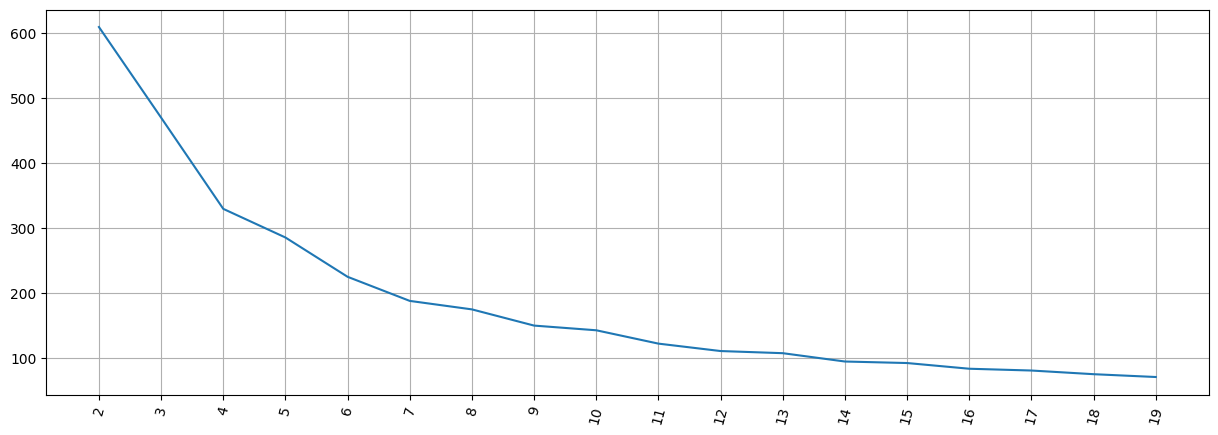

In [ ]:
distorsions = []
max_loop= 20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

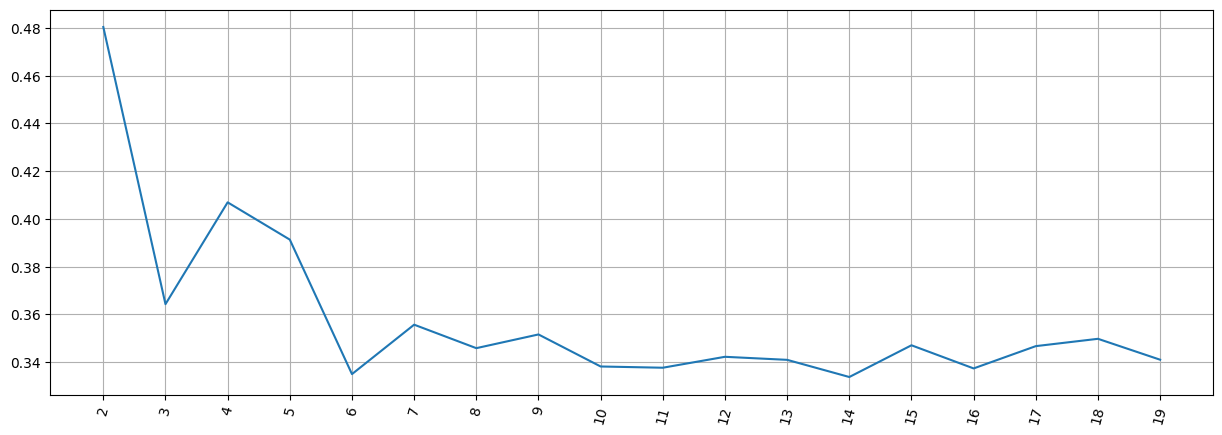

In [ ]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [ ]:
nclust=4
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=4)

In [ ]:
#Extracting labels
target_labels = k_means.predict(X)

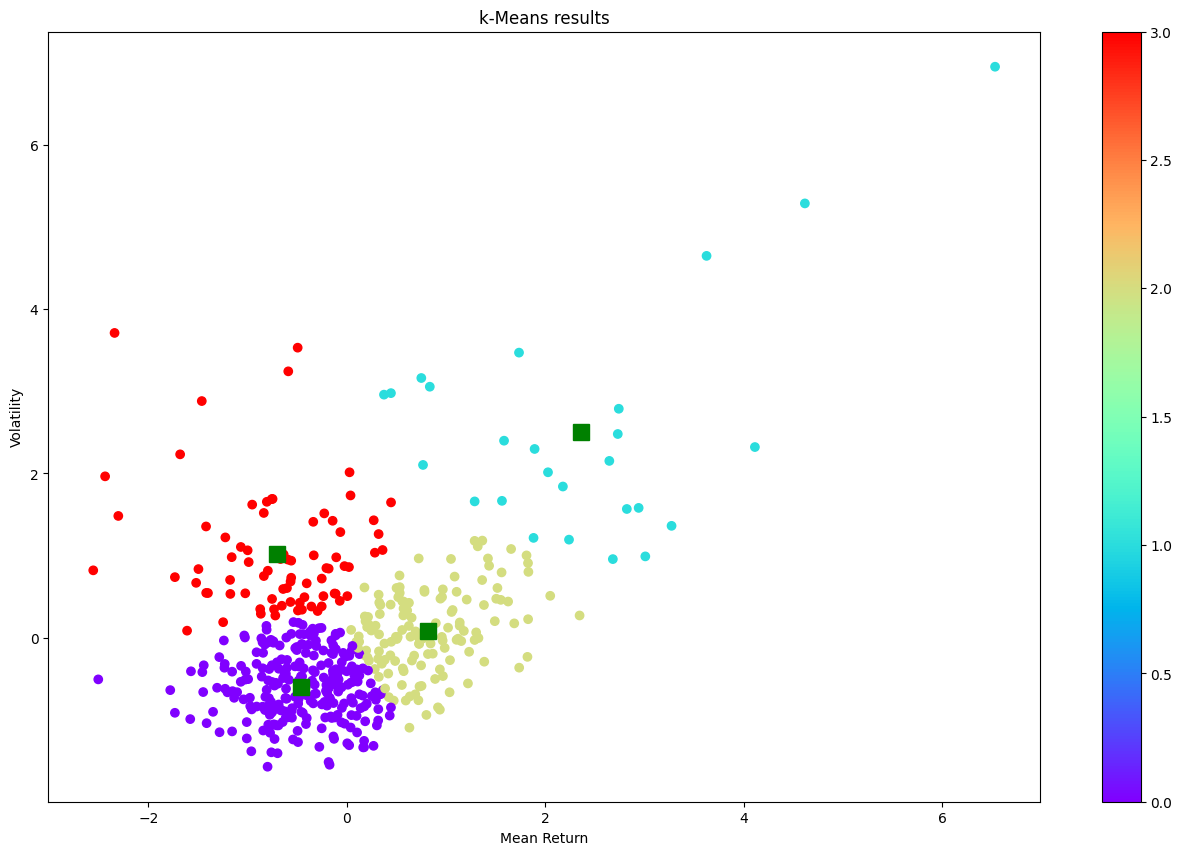

In [ ]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

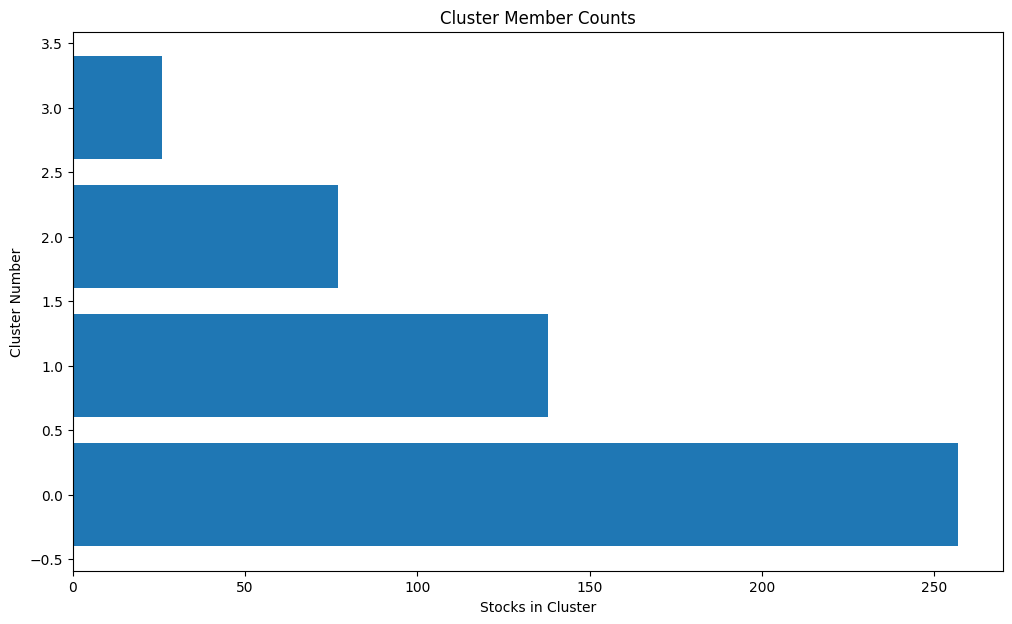

In [ ]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [ ]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [ ]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[2]

In [ ]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 109546


In [ ]:
# plot a handful of the smallest clusters
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 5)]

[2]

<Figure size 1200x700 with 0 Axes>

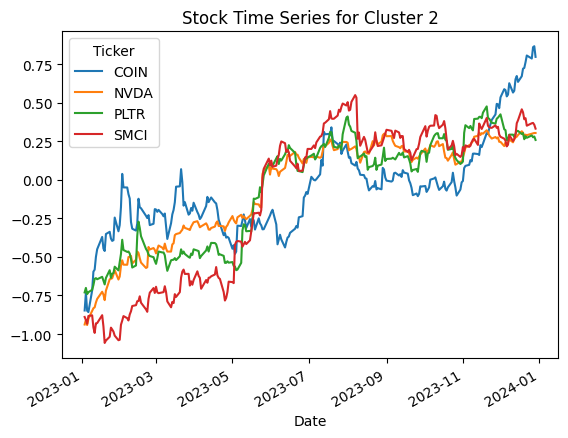

In [ ]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 5)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(adj_close.loc[:, tickers].mean())
    data = np.log(adj_close.loc[:, tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
plt.show()

# Pair Selection

In [ ]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [ ]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        adj_close[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [ ]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])


In [ ]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs found : 28
In those pairs, there are 31 unique tickers.
[('A', 'DIS'), ('A', 'DOW'), ('A', 'DUK'), ('A', 'SRE'), ('ABNB', 'CARR'), ('ABNB', 'CCL'), ('ABNB', 'CPAY'), ('ABNB', 'DDOG'), ('ABNB', 'DLR'), ('ABNB', 'DVA'), ('ABNB', 'ETN'), ('ABNB', 'HUBB'), ('ABNB', 'NTAP'), ('ABNB', 'NXPI'), ('ABNB', 'ORCL'), ('ABNB', 'PNR'), ('ABNB', 'PWR'), ('ABNB', 'TSLA'), ('ABNB', 'VRTX'), ('ABNB', 'WDAY'), ('AES', 'DG'), ('AES', 'MKTX'), ('AES', 'PARA'), ('AES', 'PYPL'), ('AES', 'TGT'), ('AES', 'TPR'), ('AES', 'WBD'), ('AES', 'ZBRA')]


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [ ]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [ ]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

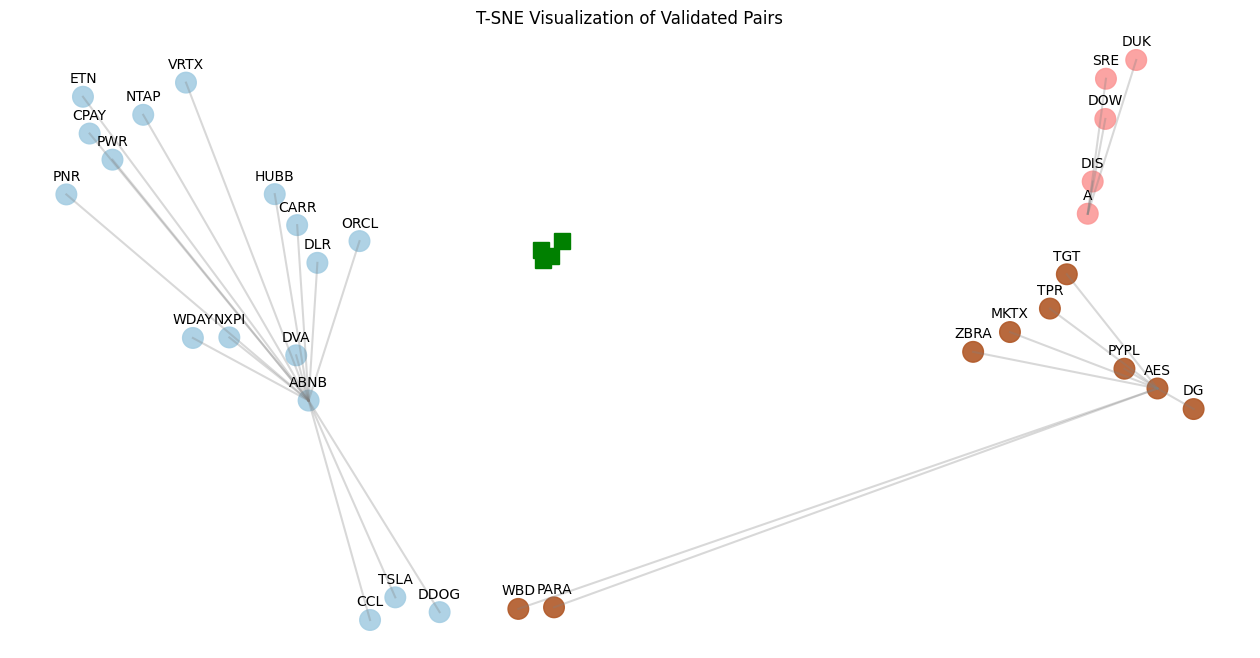

In [ ]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]

    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

**Conintegration**

In [ ]:
S1=adj_close['ABNB']
S2=adj_close['CARR']
score, pvalue, _ = coint(S1, S2)
pvalue
if pvalue < 0.05 :
  print("Cointegrated")
else:
  print("Not Cointegrated")

Cointegrated


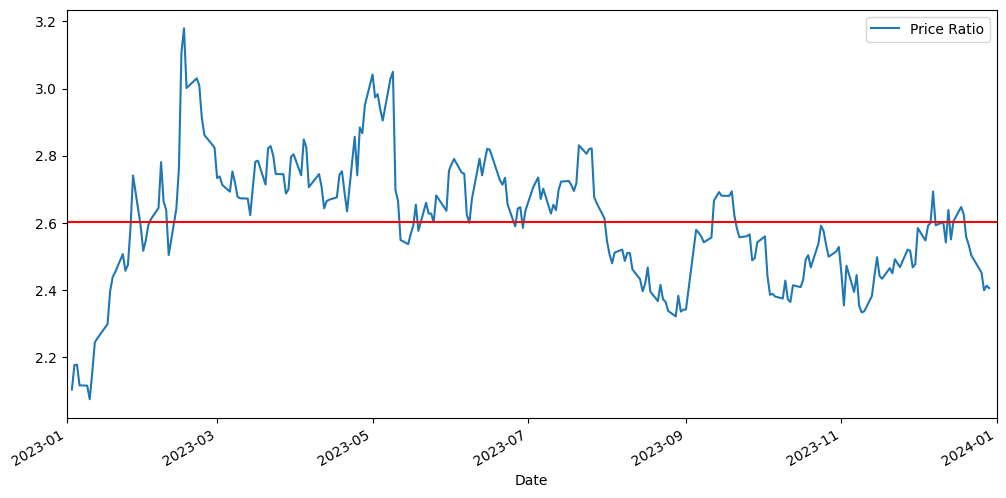

In [ ]:
ratio1 = S1/S2
ratio1.plot(figsize=(12,6))
plt.axhline(ratio1.mean(), color='red')
plt.xlim('2023-01-01', '2024-01-01')
plt.legend(['Price Ratio']);

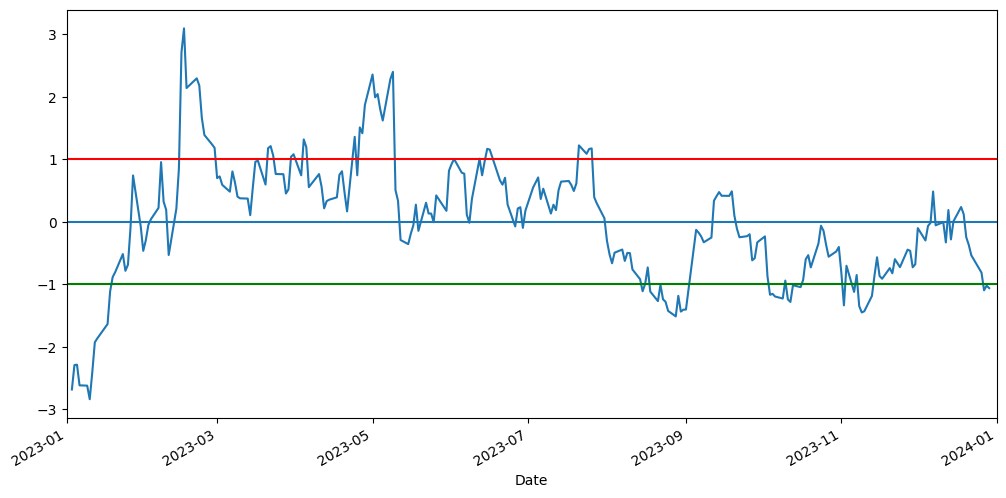

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(ratio1).plot(figsize=(12,6))
plt.axhline(zscore(ratio1).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2023-01-01', '2024-01-01')
plt.show()

# Trading

In [ ]:
print(len(ratio1) * .70 )

175.0


In [ ]:
train= ratio1[:175]
test = ratio1[175:]

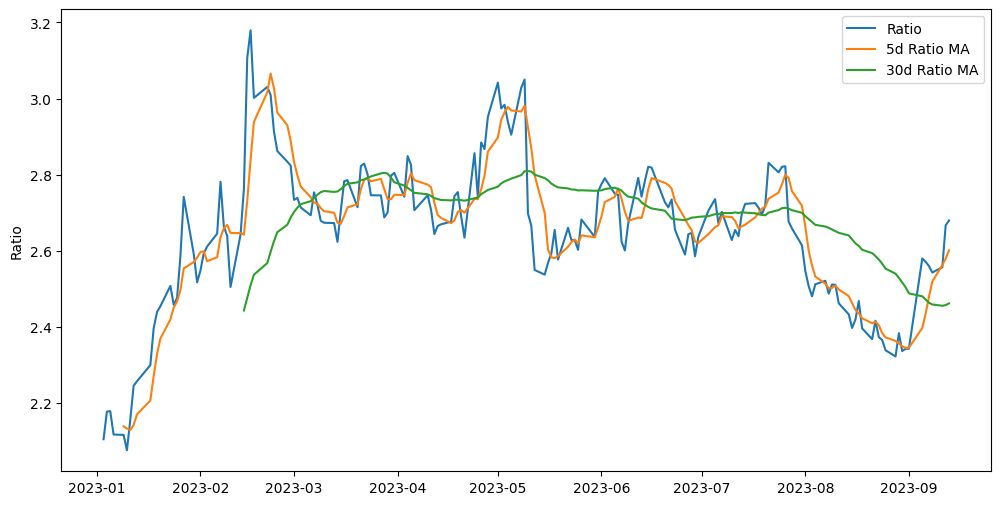

In [ ]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg30 = train.rolling(window=30, center=False).mean()
std_30 = train.rolling(window=30, center=False).std()
zscore_30_5 = ((ratios_mavg5 - ratios_mavg30)/std_30).shift(1)
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg30.index, ratios_mavg30.values)
plt.legend(['Ratio', '5d Ratio MA', '30d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

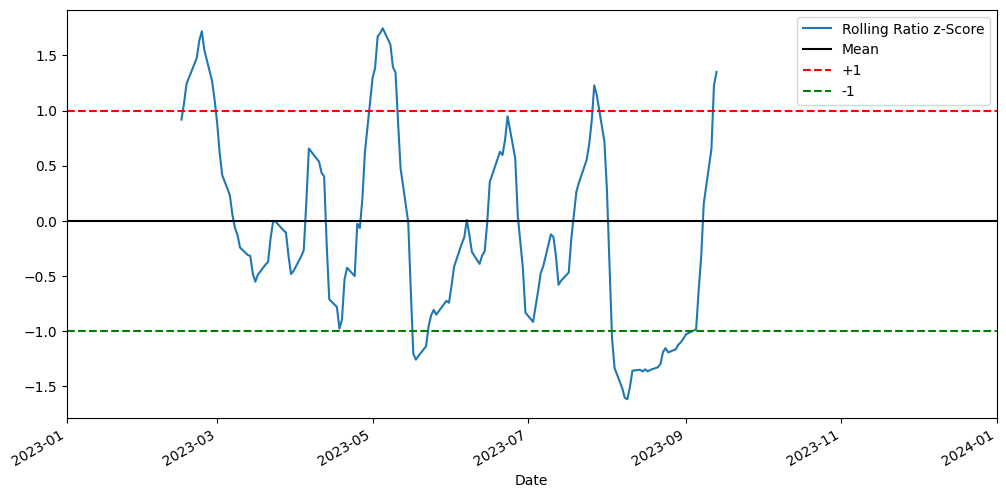

In [ ]:
plt.figure(figsize=(12,6))
zscore_30_5.plot()
plt.xlim('2023-01-01', '2024-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

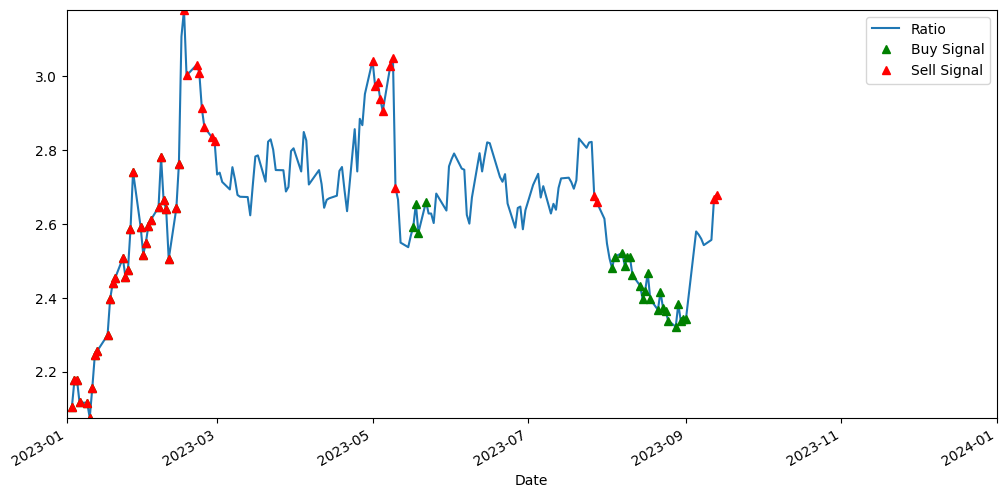

In [ ]:
plt.figure(figsize=(12,6))

train[:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_30_5>-1] = 0
sell[zscore_30_5<1] = 0
buy[:].plot(color='g', linestyle='None', marker='^')
sell[:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio1.min(), ratio1.max()))
plt.xlim('2023-01-01','2024-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

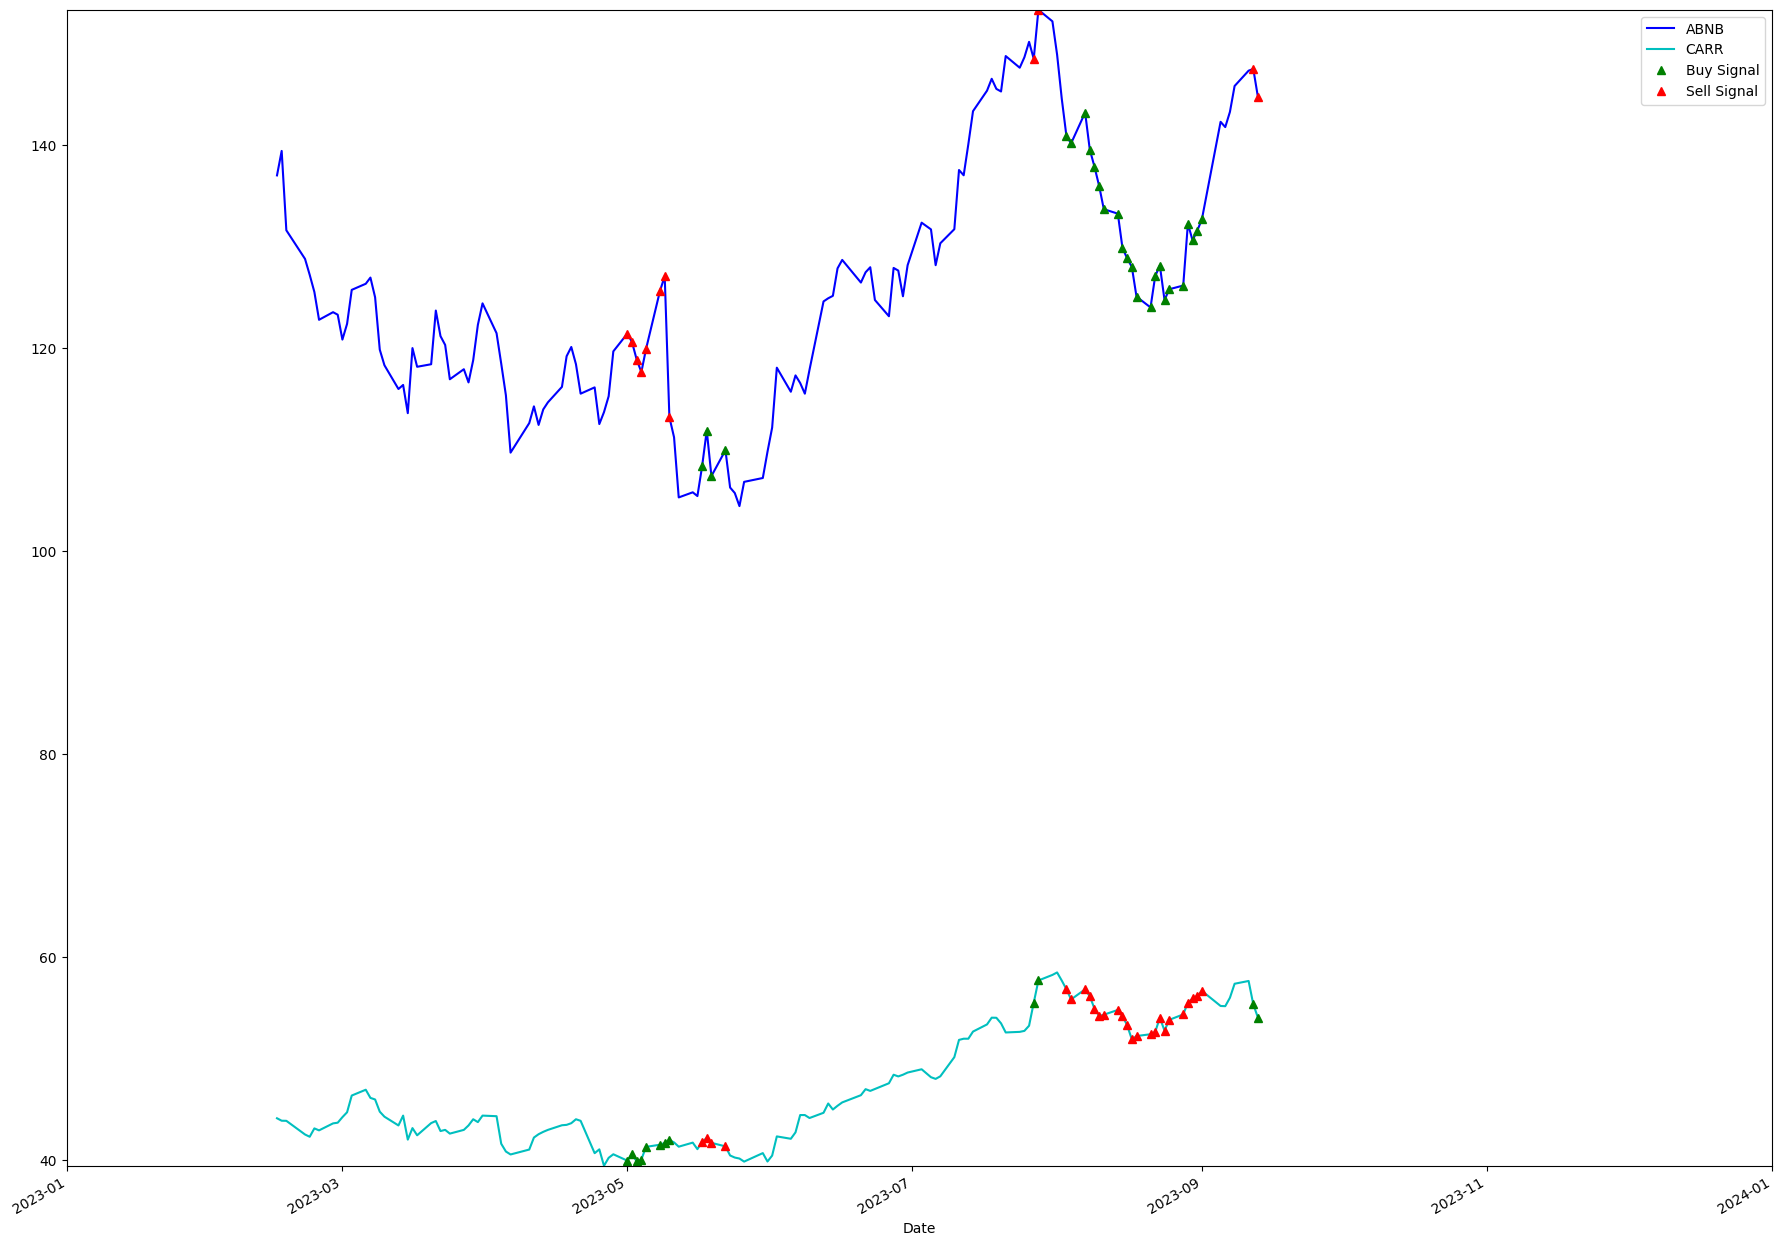

In [ ]:
plt.figure(figsize=(22,17))
S1 = adj_close['ABNB'].iloc[:175]
S2 = adj_close['CARR'].iloc[:175]

S1[30:].plot(color='b')
S2[30:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.xlim('2023-01-01', '2024-01-01')

plt.legend(['ABNB', 'CARR', 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [ ]:
print(trade(adj_close['ABNB'].iloc[175:], adj_close['CARR'].iloc[175:], 30, 5))

134.87664485180437


##  Conclusion

In this notebook, we explored a quantitative approach to **pairs trading** using clustering and statistical arbitrage techniques. Below is a summary of our findings and results:

###  Strategy Summary

- We began by retrieving the **S&P 500 constituent stocks** and downloaded one year of **adjusted closing prices** using `yfinance`.
- From this data, we computed each stock’s **annualized return and volatility**, forming a two-dimensional **risk-return feature space**.
- Using **KMeans clustering**, we grouped similar stocks into clusters, assuming that assets in the same cluster exhibit comparable statistical behaviors.
- We then selected stock pairs **within the same cluster**, improving the likelihood of identifying cointegrated or mean-reverting relationships.

###  Trade Signal Construction

- Rather than using traditional linear regression to calculate the spread, we adopted a **ratio-based z-score approach**.
- We computed the **rolling mean and standard deviation** of the price ratio between each pair, generating z-scores that act as standardized indicators of divergence.
- Entry and exit rules were applied based on z-score thresholds (e.g., enter short when z-score > 1, go long when z-score < -1, exit when z-score returns to 0).

###  Backtest Performance (Summary from Plots)

- The **z-score plots** clearly showed multiple instances of mean reversion, indicating the presence of short-term mispricings in selected pairs.
- The **cumulative return curve** demonstrated that the strategy can be profitable under ideal assumptions (e.g., zero transaction costs, perfect execution).
- The strategy's performance is strongly tied to the **quality of clustering** and **stability of the ratio** over time.

###  Limitations

- The backtest does **not yet account for transaction costs, slippage, or execution risk** — these must be added for realistic evaluation.
- The strategy assumes **static hedge ratios and relationships**, which may change over time. A rolling or dynamic model would likely improve robustness.
- The use of KMeans assumes **linear separability and equal cluster variance**, which may not reflect actual market dynamics.

###  Future Enhancements

- Introduce **advanced clustering algorithms** such as Agglomerative, Spectral, DBSCAN, and graph-based methods to capture more complex relationships.
- Add **stationarity tests** on the ratio to validate that it truly mean-reverts (ADF, KPSS).
- Improve pair selection using **supervised ML classifiers** that predict pair profitability based on statistical features.
- Use **rolling window regression** or **Kalman Filters** to update hedge ratios dynamically.
- Implement a **realistic trading simulator** that includes execution constraints and transaction costs.


By combining statistical modeling with machine learning tools like clustering, this project demonstrates how modern data science can be used to extract trading signals from financial time series data. While the current strategy is simplified, it provides a solid foundation for building more sophisticated and production-ready trading systems.
